In [2]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})



In [3]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def bind(past, present):
    return np.multiply(past, present)

def reg_bind(past, present):
    pred = np.multiply(tv, present)
    return ((N-sim(pred, past))/float(N)) * np.multiply(past, present)

def bind_diff(past2, present1, present2):
    return np.multiply(present1, past2-present2)

def reg_bind_diff(past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    return ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)

def closed_bind(past, present):
    return np.dot(np.linalg.pinv(present), past)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

In [4]:
def state_setup(state_length, letter_vecs, N, D, n_steps):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

def iterate(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, n_steps):
    for i in range(n_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])
            
            if j == 1:
                ljd = (np.roll(bound_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  bound_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(bound_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(bound_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      bound_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(bound_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(bound_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N)
            states[j] = states[j]/norm(states[j])

    return states, coef_hists

In [5]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 3000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


word_key = 2 * (np.random.randn(N) < 0) - 1

ngram_strs = ['pax', 'max', 'the', 'run', 'ran', 'fun', 'fan', 'top', 'pop', 'off', 'cup', 'cap', 'rap', 'pup', 'pan', 'pun']
#ngram_strs = ['pax', 'max', 'the']
bound_vec = np.zeros(N)

n_steps = 100

In [6]:
# unregularized bind
word_length = 3
unbind_idx = 3

for istr, ngram_str in enumerate(ngram_strs):
    vv = ngram_encode_cl(ngram_str, letter_vecs, alph)
    bound_vec += np.roll(word_key, istr) * vv

In [7]:
# regularized bind
word_length = 3
unbind_idx = 3
for istr, ngram_str in enumerate(ngram_strs):
    vv = ngram_encode_cl(ngram_str, letter_vecs, alph)
    pred = np.multiply(bound_vec, vv)
    bound_vec += np.roll(word_key, istr) * vv * ((N-sim(pred, vv))/float(N))

In [8]:
# predict a word in bound_vec
bound_vec = np.roll(word_key, unbind_idx) * bound_vec

In [9]:
states, coef_hists = state_setup(word_length+2, letter_vecs, N, D, n_steps)
states, coef_hists = iterate(bound_vec, states, coef_hists, word_length+2, letter_vecs, N, D, n_steps)

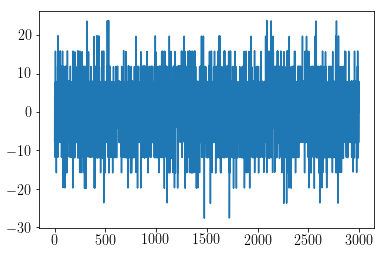

In [10]:
plot(bound_vec)

run


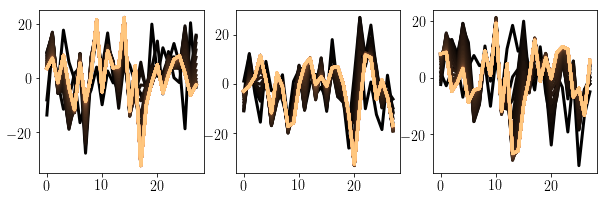

In [11]:
figure(figsize=(10,3))
cols = get_cmap('copper', min(50,n_steps))
for i in range(min(50,n_steps)):
    subplot(131)
    plot(coef_hists[0][i,:], lw=3, c=cols(i))
    subplot(132)
    plot(coef_hists[1][i,:], lw=3, c=cols(i))
    subplot(133)
    plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
pred = ''
for i in range(len(coef_hists)):
    pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

print pred

In [12]:
# PAST-PRESENT TENSE
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 6000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1

word_key = 2 * (np.random.randn(N) < 0) - 1

present_strs = ['run', 'walk', 'watch', 'catch', 'sit', 'cough', 'fight']
past_strs = ['ran', 'walked', 'watched', 'caught', 'sat', 'coughed', 'fought']
ngram_strs = present_strs + past_strs
bound_vec = np.zeros(N)
reg_bound_vec = np.zeros(N)
n_steps = 100

for i in range(len(past_strs)):
    past = ngram_encode_cl(past_strs[i], letter_vecs, alph)
    pres = ngram_encode_cl(present_strs[i], letter_vecs, alph)
    
    bound_vec += past*pres
    reg_bound_vec += ((N-sim(reg_bound_vec*pres, past))/float(N)) * past*pres
    

In [13]:
# predict a word in bound_vec
# unregularized bind
word_length = 3
pred_vec = ngram_encode_cl('run', letter_vecs, alph) * bound_vec

In [14]:
# predict a word NOT in bound_vec
word_length1 = 6
pred_vec1 = ngram_encode_cl('talk', letter_vecs, alph) * bound_vec

In [15]:
states, coef_hists = state_setup(word_length+2, letter_vecs, N, D, n_steps)
states, coef_hists = iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs, N, D, n_steps)

run


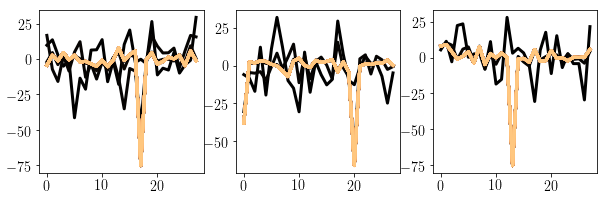

In [16]:
figure(figsize=(10,3))
cols = get_cmap('copper', min(50,n_steps))
for i in range(min(50,n_steps)):
    subplot(131)
    plot(coef_hists[0][i,:], lw=3, c=cols(i))
    subplot(132)
    plot(coef_hists[1][i,:], lw=3, c=cols(i))
    subplot(133)
    plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
pred = ''
for i in range(len(coef_hists)):
    pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

print pred
# regularized isn't much better

In [17]:
# PAST PRESENT TENSE DIFFERENCE
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 6000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1
letter_vecs1 = 2 * (np.random.randn(D, N) < 0) - 1

word_key = 2 * (np.random.randn(N) < 0) - 1

present_strs = ['run', 'walk', 'watch', 'catch', 'sit']
past_strs = ['ran', 'walked', 'watched', 'caught', 'sat']
ngram_strs = present_strs + past_strs
bound_vec = np.zeros(N)
reg_bound_vec = np.zeros(N)
n_steps = 100

for i in range(len(past_strs)):
    past = ngram_encode_cl(past_strs[i], letter_vecs, alph)
    pres = ngram_encode_cl(present_strs[i], letter_vecs, alph)
    past1 = ngram_encode_cl(past_strs[i], letter_vecs1, alph)
    pres1 = ngram_encode_cl(present_strs[i], letter_vecs1, alph)
    
    bound_diff = pres * (past1 - pres1)
    pred = reg_bound_vec*pres + pres1

    bound_vec += bound_diff
    reg_bound_vec += ((N-sim(pred, past1))/float(N)) * bound_diff

In [18]:
# predict a word in bound_vec
# unregularized bind
word_length = 6
word_vec = ngram_encode_cl('walk', letter_vecs, alph)
word_vec1 = ngram_encode_cl('walk', letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [19]:
states, coef_hists = state_setup(word_length+2, letter_vecs1, N, D, n_steps)
states, coef_hists = iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs1, N, D, n_steps)

walklk


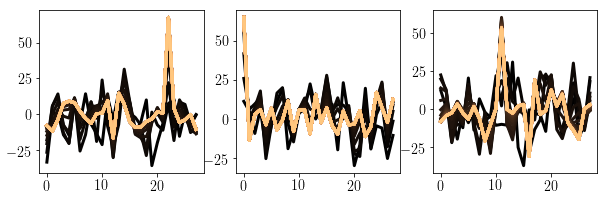

In [20]:
figure(figsize=(10,3))
cols = get_cmap('copper', min(50,n_steps))
for i in range(min(50,n_steps)):
    subplot(131)
    plot(coef_hists[0][i,:], lw=3, c=cols(i))
    subplot(132)
    plot(coef_hists[1][i,:], lw=3, c=cols(i))
    subplot(133)
    plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
pred = ''
for i in range(len(coef_hists)):
    pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

print pred

In [405]:
# predict a word in bound_vec
# regularized bind
word_length = 6
word_vec = ngram_encode_cl('walk', letter_vecs, alph)
word_vec1 = ngram_encode_cl('walk', letter_vecs1, alph)

reg_pred_vec = word_vec * reg_bound_vec + word_vec1

In [406]:
states, coef_hists = state_setup(word_length+2, letter_vecs1, N, D, n_steps)
states, coef_hists = iterate(reg_pred_vec, states, coef_hists, word_length+2, letter_vecs1, N, D, n_steps)

walklk


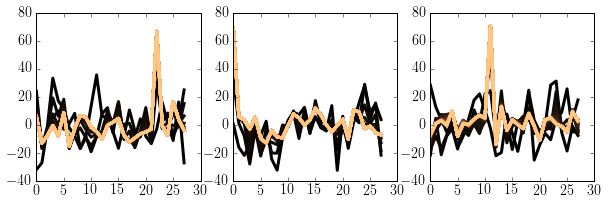

In [407]:
figure(figsize=(10,3))
cols = get_cmap('copper', min(50,n_steps))
for i in range(min(50,n_steps)):
    subplot(131)
    plot(coef_hists[0][i,:], lw=3, c=cols(i))
    subplot(132)
    plot(coef_hists[1][i,:], lw=3, c=cols(i))
    subplot(133)
    plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
pred = ''
for i in range(len(coef_hists)):
    pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

print pred

In [165]:
# EXPLAIN AWAY, PAST PRESENT TENSE DIFFERENCE
def explain_away_iterate(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, n_steps):
    th_vec = bound_vec.copy()
    
    for i in range(n_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            #mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            #states[j] *= np.sign(coef_hists[j-1][i, mxidx])
            
            if j == 1:
                ljd = (np.roll(th_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N) + 1.0*states[j]
            #states[j] = states[j]/norm(states[j])
            
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        #bv = 2*(bv > 0) - 1

        th_vec = bound_vec - bv

    return states, coef_hists


In [181]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 10000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1
letter_vecs1 = 2 * (np.random.randn(D, N) < 0) - 1

word_key = 2 * (np.random.randn(N) < 0) - 1

present_strs = ['run', 'walk', 'watch', 'catch', 'sit', 'jump', 'lump', 'bump', 'think']
past_strs = ['ran', 'walked', 'watched', 'caught', 'sat', 'jumped', 'lumped', 'bumped', 'thought']
#present_strs = ['run', 'walk']
#past_strs = ['ran', 'walked']

ngram_strs = present_strs + past_strs
bound_vec = np.zeros(N)
reg_bound_vec = np.zeros(N)
n_steps = 100

for i in range(len(past_strs)):
    past = ngram_encode_cl(past_strs[i], letter_vecs, alph)
    pres = ngram_encode_cl(present_strs[i], letter_vecs, alph)
    past1 = ngram_encode_cl(past_strs[i], letter_vecs1, alph)
    pres1 = ngram_encode_cl(present_strs[i], letter_vecs1, alph)
    
    bound_diff = pres * (past1 - pres1)
    pred = reg_bound_vec*pres + pres1

    bound_vec += bound_diff
    reg_bound_vec += ((N-sim(pred, past1))/float(N)) * bound_diff

In [176]:
# predict a word in bound_vec
# unregularized bind
word = 'catch'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [182]:
# predict a word not bound_vec
# unregularized bind
word_length = 6
word_vec = ngram_encode_cl('pump', letter_vecs, alph)
word_vec1 = ngram_encode_cl('pump', letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [183]:
states, coef_hists = state_setup(word_length+2, letter_vecs1, N, D, n_steps)

In [184]:
states, coef_hists = explain_away_iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs1, N, D, n_steps)
#states, coef_hists = iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs1, N, D, n_steps)

pumped


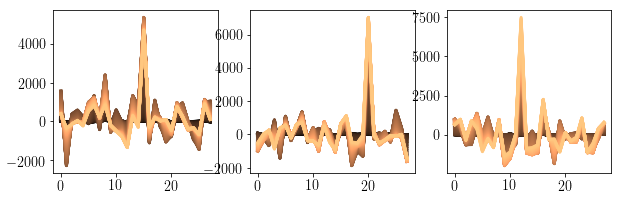

In [185]:
figure(figsize=(10,3))
cols = get_cmap('copper', min(500,n_steps))
for i in range(min(500,n_steps)):
    subplot(131)
    plot(coef_hists[0][i,:], lw=3, c=cols(i))
    subplot(132)
    plot(coef_hists[1][i,:], lw=3, c=cols(i))
    subplot(133)
    plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
pred = ''
for i in range(len(coef_hists)):
    pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

print pred

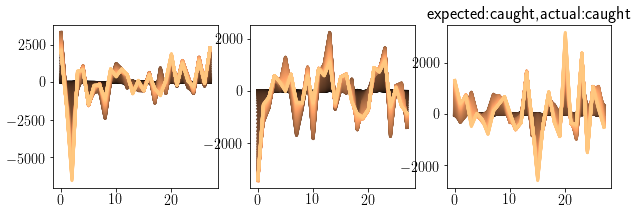

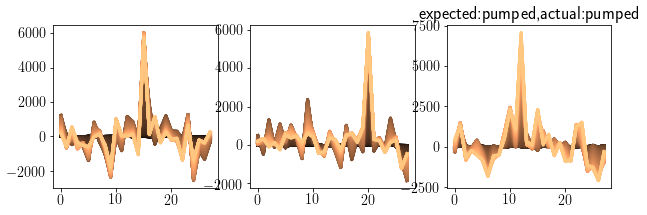

In [191]:
# REGRESSION
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 10000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1
letter_vecs1 = 2 * (np.random.randn(D, N) < 0) - 1

def closed_train(diff, pred, rcond=1e-15): # 5e-2
    return np.dot(np.linalg.pinv(diff,rcond), pred)

def diff_trigram_regress(pres1, past2, pres2, b, rcond=1e-15):
    return closed_train(past2-pres2, b*pres1, rcond)

def predict(word, word_length, pred_vec, pair, W, nsteps=100):
    states, coef_hists = state_setup(word_length+2, letter_vecs1, N, D, n_steps)
    states, coef_hists = explain_away_iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs1, N, D, n_steps)

    figure(figsize=(10,3))
    cols = get_cmap('copper', min(500,n_steps))
    for i in range(min(500,n_steps)):
        subplot(131)
        plot(coef_hists[0][i,:], lw=3, c=cols(i))
        subplot(132)
        plot(coef_hists[1][i,:], lw=3, c=cols(i))
        subplot(133)
        plot(coef_hists[2][i,:], lw=3, c=cols(i))
    
    pred = ''
    for i in range(len(coef_hists)):
        pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]
    plt.title('expected:'+pair[1]+',actual:'+pred)

def demo(W, nsteps=100):
    # predict a word in bound_vec
    # unregularized bind
    word = 'catch'
    word_length = 6
    word_vec = ngram_encode_cl(word, letter_vecs, alph)
    word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

    pred_vec = word_vec * bound_vec + word_vec1
    predict(word, word_length, pred_vec, ['catch', 'caught'], W)
        
    # predict a word not bound_vec
    # unregularized bind
    word = 'pump'
    word_length = 6
    word_vec = ngram_encode_cl(word, letter_vecs, alph)
    word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

    pred_vec = word_vec * bound_vec + word_vec1
    predict(word, word_length, pred_vec, ['pump','pumped'], W)


present_strs = ['run', 'walk', 'watch', 'catch', 'sit', 'jump', 'lump', 'bump', 'think']
past_strs = ['ran', 'walked', 'watched', 'caught', 'sat', 'jumped', 'lumped', 'bumped', 'thought']

bound_vec = np.zeros(N)
reg_bound_vec = np.zeros(N)
n_steps = 100
vecs = {'pres1':[], 'pres2':[], 'past1':[], 'past2':[]}
for i in range(len(past_strs)):
    past = ngram_encode_cl(past_strs[i], letter_vecs, alph)
    pres = ngram_encode_cl(present_strs[i], letter_vecs, alph)
    past1 = ngram_encode_cl(past_strs[i], letter_vecs1, alph)
    pres1 = ngram_encode_cl(present_strs[i], letter_vecs1, alph)
    
    vecs['past1'].append(past)
    vecs['pres1'].append(pres)
    vecs['past2'].append(past1)
    vecs['pres2'].append(pres1)
    
    bound_diff = pres * (past1 - pres1)
    pred = reg_bound_vec*pres + pres1

    bound_vec += bound_diff
    reg_bound_vec += ((N-sim(pred, past1))/float(N)) * bound_diff
    
for k, v in vecs.items():
    vecs[k] = np.array(v)
    
W = diff_trigram_regress(vecs['pres1'], vecs['past2'], vecs['pres2'], bound_vec, 5e-2)
demo(W)

In [159]:
# GRADIENT STEPS, EXPLAIN AWAY, PAST PRESENT TENSE DIFFERENCE
def graph(coef_hists, n_steps):
    figure(figsize=(10,3))
    cols = get_cmap('copper', min(50,n_steps))
    for i in range(min(50,n_steps)):
        subplot(131)
        plot(coef_hists[0][i,:], lw=3, c=cols(i))
        subplot(132)
        plot(coef_hists[1][i,:], lw=3, c=cols(i))
        subplot(133)
        plot(coef_hists[2][i,:], lw=3, c=cols(i))
        
def predict(alph, letter_vecs, coef_hists):
    pred = ''
    for i in range(len(coef_hists)):
        pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]
    pred_vec = ngram_encode_cl(pred, letter_vecs, alph)
    return pred_vec, pred

def gradient_iterate(bound_vec, pres, pres1, past1, states, coef_hists, \
                     state_length, alph, letter_vecs, N, D, n_steps, grad_thresh):
    th_vec = bound_vec.copy()
    
    prev_pred_vec, _ = predict(alph, letter_vecs, coef_hists)
 
    for i in range(n_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])
            
            if j == 1:
                ljd = (np.roll(th_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = 3.5*np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N) + 1.0*states[j]
            states[j] = states[j]/norm(states[j])
            
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        bv = 2*(bv > 0) - 1

        th_vec = bound_vec - bv
        
        pred_vec, pred_str = predict(alph, letter_vecs, coef_hists)

        slope, intercept, r_value, p_value, std_err = stats.linregress(prev_pred_vec, pred_vec)
        if abs(slope) <= grad_thresh:
            print ('slope ', slope, 'step ', i)
            return states, coef_hists
        prev_pred_vec = pred_vec
    return states, coef_hists

In [160]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 6000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1
letter_vecs1 = 2 * (np.random.randn(D, N) < 0) - 1

word_key = 2 * (np.random.randn(N) < 0) - 1

present_strs = ['run', 'walk']
past_strs = ['ran', 'walked']
ngram_strs = present_strs + past_strs
bound_vec = np.zeros(N)
reg_bound_vec = np.zeros(N)
n_steps = 100
grad_thresh = .01

for i in range(len(past_strs)):
    past = ngram_encode_cl(past_strs[i], letter_vecs, alph)
    pres = ngram_encode_cl(present_strs[i], letter_vecs, alph)
    past1 = ngram_encode_cl(past_strs[i], letter_vecs1, alph)
    pres1 = ngram_encode_cl(present_strs[i], letter_vecs1, alph)
    
    bound_diff = pres * (past1 - pres1)
    pred = reg_bound_vec*pres + pres1

    bound_vec += bound_diff
    reg_bound_vec += ((N-sim(pred, past1))/float(N)) * bound_diff

In [161]:
# predict a word in bound_vec
# unregularized bind
word_length = 6
word_vec = ngram_encode_cl('walk', letter_vecs, alph)
word_vec1 = ngram_encode_cl('walk', letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [157]:
# predict a word not bound_vec
# unregularized bind
word_length = 6
word_vec = ngram_encode_cl('talk', letter_vecs, alph)
word_vec1 = ngram_encode_cl('talk', letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [162]:
states, coef_hists = state_setup(word_length+2, letter_vecs1, N, D, n_steps)
states, coef_hists = gradient_iterate(pred_vec,
                             word_vec,
                             word_vec1,
                             ngram_encode_cl('talked', letter_vecs1, alph),
                             states, coef_hists, word_length+2,
                             alph,
                             letter_vecs1,
                             N,
                             D,
                             n_steps,
                             grad_thresh)

(array([-1,  1,  1, ...,  1,  1, -1]), 'wafylw')


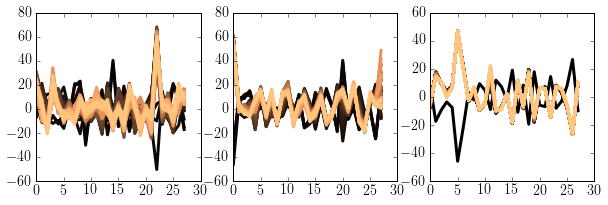

In [163]:
print predict(alph, letter_vecs, coef_hists)
graph(coef_hists, n_steps)

In [ ]:
# UM. Idk why this one's broken...